# Lecture 3 - HJB Equations

This follows the lecture notes produced by Ben Moll. Particularly the [third lecture](https://benjaminmoll.com/wp-content/uploads/2019/07/Lecture3_2149.pdf) under "Distributional Macroeconomcis".

The HJB for a neoclassical growth model can be represented as:

$$
\rho v(k) = \max_c u(c) + v'(k)(F(k) - \delta k - c)
$$

We use functional forms $F(k) = k^\alpha$ and $u(c) = \frac{c^{- \sigma}}{1 - \sigma}$

# Finite Differences

Approximate $v(k)$ at $I$ discrete points in the state space $k$. We get $k_i$ for $i = 1, 2, 3... I$. Distance between two points is $\Delta k$

Short hand notation: $v_i = v(k_i)$

The finite difference version of the HJB is:

$$
\rho v_i = \max_c u(c_i) + v'_i (F(k_i) - \delta k_i - c_i)
$$

Where $c_i = (u')^{-1}(v_i)$.

$v'_i$ is one of backward, forward or central FD approximations.

$$
v'_i \approx \frac{v_i - v_{i-1}}{\Delta k} = v'_{i, B} \tag{backward}
$$

$$
v'_i \approx \frac{v_{i+1} - v}{\Delta k} = v'_{i, F} \tag{forward}
$$

$$
v'_i \approx \frac{v_{i+1} - v_{i-1}}{2 \Delta k} = v'_{i, C} \tag{central}
$$

In [1]:
] activate .

 Activating environment at `C:\Users\Hariharan\Documents\git_repos\ben_moll_lecture_code\Project.toml`


In [27]:
using LinearAlgebra, Parameters, Plots, SparseArrays
using BenchmarkTools

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1260


In [3]:
# Storing parameters
opgrowth = @with_kw (α = 0.3, 
    A = 1, σ = 2, ρ = 0.05, 
    δ = 0.05, N = 150,
    Δ = 0.9)

function u(c, σ = 2.0)
    # CRRA utility
   
    if σ == zero(σ)
        u = log.(c)
    else
        u = (c.^(1 - σ))/(1 - σ)
    end
    
    return u
end

function udash(c, σ = 2.0)
    
    # derivate of crra
    
    udash = c.^(-σ)
    
    return udash
    
    
end

function udash_inv(x, σ = 2.0)
    # Inverse of the derivative
    # of CRRA
    
    udash_inv = x.^(-1/σ)
    
    return udash_inv
end


# Some nice formulas based on parameters
F(k, α = 0.3, A = 1.0) = A.*k.^α
Fdash(k, α = 0.3, A = 1.0) = A * α .* k .^ (α - 1)
kstar(α = 0.3, A = 1.0, ρ = 0.05, δ = 0.05) = (α * A/(ρ + δ))^(1/(1-α))
cstar(α = 0.3, A = 1.0, ρ = 0.05, δ = 0.05) = F(kstar(α, A, ρ, δ), α, A) - δ * kstar(α, A, ρ, δ)

# create kgrid
kmin = 0.001*kstar()
kmax = 2*kstar()
k = range(kmin, kmax, length = 150) |> collect;

In [4]:
# Defining forward and backward difference functions
function fdiff(x, dx)
    #==
    Forward difference
    x is an array
    ==#
    
    # initialize array
    fdiffx = zero(x)
    fdiffx[1:end-1] = (x[2:end] - x[1:end - 1])/dx
    
    return fdiffx
end

function bdiff(x, dx)
    #==
    Backward difference
    x is an array
    ==#
    
    # initialize array
    bdiffx = zero(x)
    bdiffx[2:end] = (x[2:end] - x[1:end - 1])/dx
    
    return bdiffx
end

bdiff (generic function with 1 method)

# Iterative Method / Value Function Iteration

As per the lecture slides, we first go over solving the problem with the "explicit" iteration method. It looks very similar to the simple value function iteration method one does when solving dynamic programming problems in discrete time.

Update $v^n$ to $v^{n+1}$ according to:
$$
\frac{}{}
$$

In [34]:
function viter(params, vupdate_rule; maxiter = 1000, tol = 1e-6,
    print_out = true)
    
    #==
    Solves the HJB equation. Can specify how to update
    the value function via vupdate_rule.
    vupdate_rule has to have 3 possible arguments :
    v, kgrid, and params
    ==#
    
    @unpack α, A, σ, ρ, δ, N, Δ = params
    
    # get k grid
    kmin = 0.001*kstar()
    kmax = 2*kstar()
    kgrid = range(kmin, kmax, length = N) |> collect
    
    # Preallocate k
    kseries = zeros(N)
    cseries = zeros(N)
    
    # initial guess
    v0 = u(kgrid)
    
    # iterate    
    error = 1.0
    iter = 1
    
    while error > tol && iter < maxiter
        vout, verror, k, c = vupdate_rule(v0, kgrid, params)
        
        kseries = k
        cseries = c
        error = maximum(abs.(verror))
        
        v0 = vout
        iter += 1
    end
    
    # Output Message
    if print_out
        if iter == maxiter
            println("==========================", "\n",
                    "Convergence failed. Max iterations of $maxiter reached", "\n",
                    "Error: $error", "\n",
                    "==========================")
        else
            println("==========================", "\n",
                    "Convergence Successful!", "\n",
                    "Error: $error", "\n",
                    "Iterations: $iter", "\n",
                    "==========================")
        end
    end
    
    return v0, error, kseries, cseries
    
end

viter (generic function with 1 method)

In [35]:
function explicit_solver(v, k, params)
    #==
    Updates the value function by one step
    in the explicit method
    ==#
    
    #==
    Implicit solution method
    ==#
    
    @unpack α, A, σ, ρ, δ, N, Δ = params
    
    dk = (k[end] - k[1])/(N-1)
    
    vfdiff = fdiff(v, dk)
    vbdiff = bdiff(v, dk)
    
    # cant be negative
    vfdiff[vfdiff .< 0.0] .= 1e-6
    vbdiff[vbdiff .< 0.0] .= 1e-6
    
    cf = udash_inv(vfdiff, σ)
    cb = udash_inv(vbdiff, σ)
    
    sf = F(k, α, A) - δ .* k - cf
    sb = F(k, α, A) - δ .* k - cb
    
    css = F(k, α, A) - δ .* k
    vdiff_ss = udash(css, σ)
    
    # constructing indicators for drift
    If = sf .> 0.0
    Ib = sb .< 0.0
    
    # at the boundries
    Ib[1] = 0.0
    If[1] = 1.0
    Ib[N] = 1.0
    If[N] = 0.0
    
    # SS indicator
    I0 = 1.0 .- If - Ib
    
    # upwind
    dv = vfdiff.*If + vbdiff.*Ib + vdiff_ss.*I0
    
    # dv should never be negative
    dv[dv .< 0.0] .= 1e-6
    
    c = udash_inv(dv, σ)
    
    # updating
    vchange = u(c, σ) + dv .* (F(k, α, A) - δ .* k  - c) - ρ .* v
    
    # the following CFL condition seems to work well in practice
    # shamelessly copied from Ben Moll's code
    dk = (k[end] - k[1])/(N-1)
    Δv = Δ*dk/maximum(F(k, α, A) - δ.*k);
    vout = v + Δv*vchange
    
    return vout, vchange, k, c
    
    
end

explicit_solver (generic function with 1 method)

In [36]:
og = opgrowth()
vout, error, kseries, cseries = viter(og, explicit_solver, maxiter=10000)

Convergence Successful!
Error: 9.998919398013228e-7
Iterations: 6966


([-28.26870826023865, -22.852722375853382, -21.913078209791657, -21.31970205037967, -20.872066656335285, -20.507511826769917, -20.197548936214417, -19.926587851050126, -19.68507756216176, -19.46670148663831  …  -13.018448069790521, -12.999138999656552, -12.979959346455372, -12.960907421223897, -12.941981568134363, -12.923180163625853, -12.904501615564273, -12.885944362429678, -12.867506872529841, -12.849187643239118], 9.998919398013228e-7, [0.0048039866566730914, 0.06925478750693825, 0.13370558835720342, 0.1981563892074686, 0.26260719005773375, 0.3270579909079989, 0.3915087917582641, 0.45595959260852925, 0.5204103934587944, 0.5848611943090596  …  9.027916105693796, 9.092366906544061, 9.156817707394326, 9.221268508244592, 9.285719309094857, 9.350170109945122, 9.414620910795387, 9.479071711645652, 9.543522512495917, 9.607973313346182], [0.10908760253688661, 0.26189816059192084, 0.32957109309318944, 0.37944772198073917, 0.42046778886873504, 0.4559941887117033, 0.48770891874094857, 0.51659

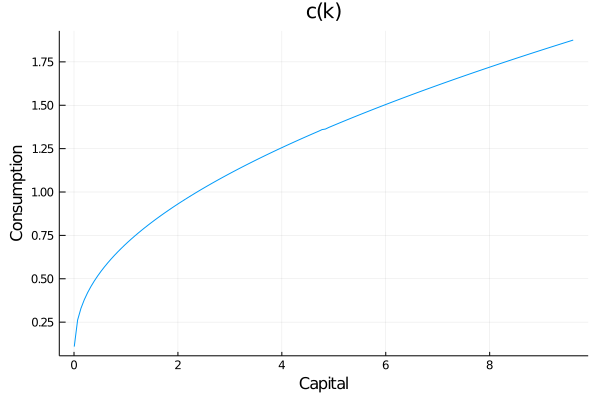

In [37]:
plot(kseries, cseries, label = "", 
    xlabel = "Capital", ylabel = "Consumption", 
    title = "c(k)")

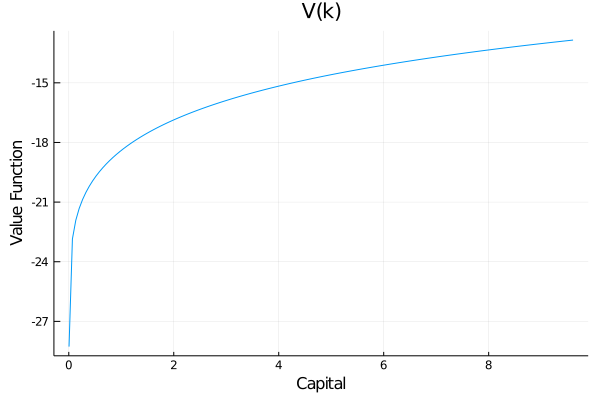

In [38]:
plot(kseries, vout, label = "", 
    xlabel = "Capital", ylabel = "Value Function", 
    title = "V(k)")

As the lecture slides warn, this takes a long time to converge! 

So we should give the implicit method a shot.

In [39]:
function implicit_solver(v, k, params)
    #==
    Implicit solution method
    ==#
    
    @unpack α, A, σ, ρ, δ, N, Δ = params
    
    dk = (k[end] - k[1])/(N-1)
    
    vfdiff = fdiff(v, dk)
    vbdiff = bdiff(v, dk)
    vfdiff[N] = udash(F(k[end], α, A) - δ.*k[end])
    vbdiff[1] = udash(F(k[1], α, A) - δ.*k[1])
    
    # cant be negative
    vfdiff[vfdiff .<= 0.0] .= 1e-6
    vbdiff[vbdiff .<= 0.0] .= 1e-6
    
    cf = udash_inv(vfdiff, σ)
    cb = udash_inv(vbdiff, σ)
    
    sf = F(k, α, A) - δ .* k - cf
    sb = F(k, α, A) - δ .* k - cb
    
    css = F(k, α, A) - δ .* k
    vdiff_ss = udash(css, σ)
    
    # constructing indicators for drift
    If = sf .> 0.0
    Ib = sb .< 0.0
    
    # at the boundries
    Ib[1] = 0.0
    If[1] = 1.0
    Ib[N] = 1.0
    If[N] = 0.0
    
    # SS indicator
    I0 = 1.0 .- If - Ib
    
    # upwind
    dv = vfdiff.*If + vbdiff.*Ib + vdiff_ss.*I0
    
    # dv should never be negative
    dv[dv .< 0.0] .= 1e-6
    
    c = udash_inv(dv, σ)
    
    # updating
    vchange = u(c, σ) + dv .* (F(k, α, A) - δ .* k  - c) - ρ .* v
    
    # Creating Asp matrix
    sbmin = sb
    sbmin[sbmin .> 0] .= 0
    sbmin = sbmin/dk
    
    sfmax = sf
    sfmax[sfmax .< 0] .= 0
    sfmax = sfmax/dk
    
    # constructing sparse matrix
    Asp = spdiagm(-1 => -sbmin[2:end],
                0 => -sfmax + sbmin,
                1 => sfmax[1:end-1])
    
    # solving
    lhs = (ρ + 1/Δ) * I - Asp
    rhs = u(c, σ) + (1/Δ) * v
    vout = lhs\rhs
    
    vchange = vout - v

    return vout, vchange, k, c
    
    
end

implicit_solver (generic function with 1 method)

In [40]:
og = opgrowth()
vimp, error, kimpl, cimpl = viter(og, implicit_solver, maxiter=10000)

Convergence Successful!
Error: 9.739394464247653e-7
Iterations: 307


([-28.26870657608062, -22.852720691695353, -21.91307652563363, -21.31970036622165, -20.872064972177263, -20.507510142611903, -20.197547252056403, -19.926586166892108, -19.685075878003744, -19.466699802480292  …  -13.018446386095935, -12.999137315961965, -12.979957662760786, -12.96090573752931, -12.941979884439775, -12.923178479931265, -12.904499931869687, -12.88594267873509, -12.867505188835251, -12.849185959544526], 9.739394464247653e-7, [0.0048039866566730914, 0.06925478750693825, 0.13370558835720342, 0.1981563892074686, 0.26260719005773375, 0.3270579909079989, 0.3915087917582641, 0.45595959260852925, 0.5204103934587944, 0.5848611943090596  …  9.027916105693796, 9.092366906544061, 9.156817707394326, 9.221268508244592, 9.285719309094857, 9.350170109945122, 9.414620910795387, 9.479071711645652, 9.543522512495917, 9.607973313346182], [0.10908760253688661, 0.26189816059192084, 0.32957109309319144, 0.37944772198074217, 0.42046778886873704, 0.4559941887117033, 0.48770891874094857, 0.516590

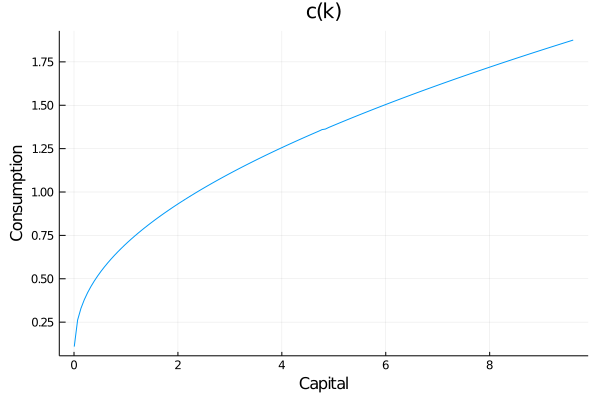

In [41]:
plot(kimpl, cimpl, label = "", 
    xlabel = "Capital", ylabel = "Consumption", 
    title = "c(k)")

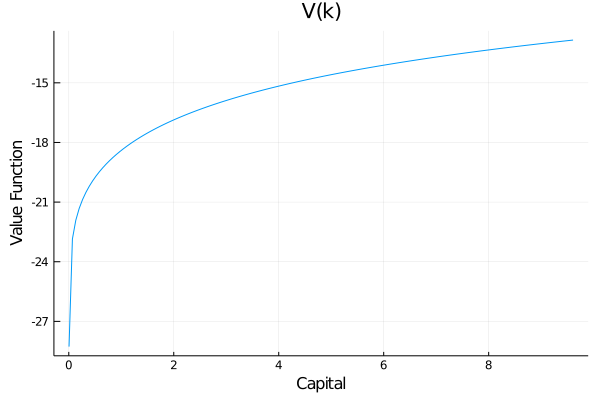

In [42]:
plot(kimpl, vimp, label = "", 
    xlabel = "Capital", ylabel = "Value Function", 
    title = "V(k)")

In [43]:
cseries ≈ cimpl && kseries ≈ kimpl

true

So the number of iterations in the implicit solver is MUCH lower than for the explicit solver. Of course we don't really care about the number of iterations in itself. We care more about the time taken for each iteration. So lets benchmark both methods.

In [48]:
# benchmarking
println("==========================", "\n",
        "Explicit Solver", "\n",
        "==========================")
@benchmark viter(og, explicit_solver, maxiter=10000, print_out = false)

Explicit Solver


BenchmarkTools.Trial: 
  memory estimate:  432.57 MiB
  allocs estimate:  487559
  --------------
  minimum time:     1.026 s (1.08% GC)
  median time:      1.030 s (1.06% GC)
  mean time:        1.036 s (1.05% GC)
  maximum time:     1.052 s (1.07% GC)
  --------------
  samples:          5
  evals/sample:     1

In [47]:
println("==========================", "\n",
        "Implicit Solver", "\n",
        "==========================")
@benchmark viter(og, implicit_solver, maxiter=10000, print_out = false)

Implicit Solver


BenchmarkTools.Trial: 
  memory estimate:  63.45 MiB
  allocs estimate:  59183
  --------------
  minimum time:     61.885 ms (2.25% GC)
  median time:      65.036 ms (2.89% GC)
  mean time:        67.215 ms (3.22% GC)
  maximum time:     87.756 ms (1.82% GC)
  --------------
  samples:          75
  evals/sample:     1

So the implicit method is clearly faster. In terms of the median time the implicit method takes only about 6 percent of the time taken by the explicit method.

So we got the same answers from both methods. Also the plots look fine so these are probably the correct way of coding these up.

I was hoping that I could write these algorithms by only referring to the lecture notes without looking at the matlab codes given. Sadly that was not possible for both the explicit iteration method, and the implicit method. In the explicit method, the CFL condition (how we update the value function from iteration to iteration) was a somewhat big thing. And I honestly didn't have much to go on there. So I had to refer to the source code.

For the implicit method, there is a portion where for the vectors of forward difference and backward differences we replace the first value of the backward difference and the last value of the forward difference with the marginal utility of the steady state value of consumption for that level in the capital grid. Had to get this from the source code as well. At this one is BIG. I first tried the code without replacing those (so those were 0 in my case) and the value function converged to something non sensical. 

I think the restrictions on the forward differences makes intuitive sense. The value for those points aren't calculated but we do know the bounds that they can be at. I think the CFL condition is a bit less intuitive.